### **Obligatorio Machine Learning**

### Imports

In [ ]:
# Encadenar iterables
from itertools import chain

# Proporciona una barra de progreso rápida
from tqdm import tqdm

# Selección aleatoria de una lista sin repetición
from random import sample

# Interfaz para hacer gráficos y visualizaciones
import matplotlib.pyplot as plt

# Computación científica
import numpy as np

# Manipulación de datos
import pandas as pd

# Para guardar y cargar modelos
from joblib import dump, load

# Extraer parches (pequeños subconjuntos de imágenes) de imágenes
from sklearn.feature_extraction.image import PatchExtractor

# data: conjunto de datos de muestra y funciones de carga
# color: convertir imágenes entre espacios de color
# feature: funciones para identificar y extraer características de imágenes
from skimage import data, color, feature

# Cambiar el tamaño de una imagen
from skimage.transform import resize, rescale

# Descarga y carga en memoria un conjunto de datos de imágenes de caras de personas famosas
from sklearn.datasets import fetch_lfw_people

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Validación cruzada
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Matriz de confusión
from sklearn.metrics import confusion_matrix

# La curva ROC
from sklearn.metrics import roc_curve , auc

# Métricas custom
from sklearn.metrics import make_scorer

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones auxiliares



In [ ]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=(62,47)):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    H = img.shape[0]
    W = img.shape[1]
    H_patch = min(H , int(scale * patch_size[0]))
    W_patch = min(W , int(scale * patch_size[1]))
    extracted_patch_size = (H_patch, W_patch)

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [ ]:
def non_max_suppression(indices, Ni, Nj, overlapThresh):
    # Si no hay rectángulos, regresar una lista vacía
    if len(indices) == 0:
        return []

    # Si las cajas son enteros, convertir a flotantes
    if indices.dtype.kind == "i":
        indices = indices.astype("float")

    # Inicializar la lista de índices seleccionados
    pick = []

    # Tomar las coordenadas de los cuadros
    x1 = np.array([indices[i,0] for i in range(indices.shape[0])])
    y1 = np.array([indices[i,1] for i in range(indices.shape[0])])
    x2 = np.array([indices[i,0]+Ni for i in range(indices.shape[0])])
    y2 = np.array([indices[i,1]+Nj for i in range(indices.shape[0])])

    # Calcula el área de los cuadros y ordena los cuadros
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Mientras todavía hay índices en la lista de índices
    while len(idxs) > 0:
        # Toma el último índice de la lista y agrega el índice a la lista de seleccionados
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Encontrar las coordenadas (x, y) más grandes para el inicio de la caja y las coordenadas (x, y) más pequeñas para el final de la caja
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calcula el ancho y alto de la caja
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calcula la proporción de superposición
        overlap = (w * h) / area[idxs[:last]]

        # Elimina todos los índices del índice de lista que tienen una proporción de superposición mayor que el umbral proporcionado
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Devuelve solo las cajas seleccionadas
    return indices[pick].astype("int")

In [ ]:
# True Positive Rate
def tpr_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  tpr = cm[1,1]/(cm[1,1]+cm[1,0])
  return tpr

# False Positive Rate
def fpr_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  fpr = cm[0,1]/(cm[0,0]+cm[0,1])
  return fpr


In [ ]:
# Define una función para realizar una ventana deslizante (sliding window) sobre una imagen.
def sliding_window(img,
                   patch_size=(62,47),  # Define el tamaño del parche (patch) basado en el primer parche positivo por defecto
                   istep=2,  # Paso de desplazamiento en la dirección i (verticalmente)
                   jstep=2,  # Paso de desplazamiento en la dirección j (horizontalmente)
                   scale=1.0):  # Factor de escala para ajustar el tamaño del parche

    # Calcula las dimensiones Ni y Nj del parche ajustadas por el factor de escala.
    Ni, Nj = (int(scale * s) for s in patch_size)

    # Itera a lo largo de la imagen en la dirección i
    for i in range(0, img.shape[0] - Ni, istep):
        # Itera a lo largo de la imagen en la dirección j
        for j in range(0, img.shape[1] - Ni, jstep):

            # Extrae el parche de la imagen usando las coordenadas actuales i, j.
            patch = img[i:i + Ni, j:j + Nj]

            # Si el factor de escala es diferente de 1, redimensiona el parche al tamaño original del parche.
            if scale != 1:
                patch = resize(patch, patch_size)

            # Usa yield para devolver las coordenadas actuales y el parche.
            # Esto convierte la función en un generador.
            yield (i, j), patch


# Armar el Dataset

Importamos el dataset LFW con los rostros los cuales consideraremos como etiquetas positivas


In [1]:
# Cargamos el dataset
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

NameError: name 'fetch_lfw_people' is not defined

Armamos los fondos que tomameros como etiquetas negativas. Estas las conseguimos desde imagenes nuestras y algunas tomadas de sklearn


In [ ]:
imgs = ['camera',
        'text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

backgrounds = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    backgrounds.append(img)

# Imagenes caseras adicionales
for i in range(31):
    filename = f'/content/drive/MyDrive/{i}.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    backgrounds.append(img)

print(len(backgrounds))

In [ ]:
model = LogisticRegression(penalty='l2',C=1, max_iter=1000)
resolution = 1
scales = [0.5,1,2,4,8]
proportion = 10
num_patches = int((proportion * len(positive_patches))/(len(scales) * len(backgrounds)))
orientations = 3
pixels_per_cell = (12, 12)
cells_per_block = (3, 3)

model_name = str(model)
experiment_name = model_name
experiment_name += '_R_' + str(resolution)
experiment_name += '_S_' + str(scales)
experiment_name += '_P_' + str(proportion)
experiment_name += '_O_' + str(orientations)
experiment_name += '_C_' + str(pixels_per_cell)
experiment_name += '_B_' + str(cells_per_block)

print(experiment_name)

In [ ]:
# Tamaño de las imágenes de rostros
positive_patches = np.array(
    [rescale(positive_patches[i],resolution)
    for i in tqdm(range(len(positive_patches)))]
    )
size = positive_patches[0].shape
print(size)

In [ ]:
# Podemos chequear las escalas que hemos elegido
im = 0  # Elegir un indice entre 0 y len(backgrounds)-1
fig, ax = plt.subplots(1,len(scales) + 1,figsize=(20,4))
for i in range(len(scales)):
  ax[i].imshow(extract_patches(backgrounds[im], 1, scales[i]).reshape((62,47)),cmap='gray')

ax[len(scales)].imshow(backgrounds[im],cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack(
    [extract_patches(im, num_patches, scale)
    for im in tqdm(backgrounds, desc='Procesando imágenes')
    for scale in scales]
    )
negative_patches.shape

In [ ]:
# Armamos la matriz de features y el vector de etiquetas
X = np.array(
    [feature.hog(image=im,
                 orientations=orientations,
                 pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block)
    for im in tqdm(chain(positive_patches, negative_patches))]
    )
y = np.zeros(X.shape[0])
y[:positive_patches.shape[0]] = 1

In [ ]:
X.shape

In [ ]:
y.shape

# Modelos


## 1) Regresión Logistica

In [ ]:
# Diccionario de scores
scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro',
           'f1':'f1_macro',
           'b_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
           'tpr': tpr_scorer,
           'fpr': fpr_scorer
           }

# Validación cruzada
scores = cross_validate(model,
                        X,
                        y,
                        verbose=2,
                        scoring=scoring,
                        cv=5)

[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   5.8s


In [ ]:
# Podemos pasarlo a data frame para mejor manejo
df_scores = pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_acc,test_prec,test_rec,test_f1,test_b_acc,test_auc,test_tpr,test_fpr
0,3.646281,0.226270,0.978786,0.920110,0.966817,0.941859,0.966817,0.996070,0.952021,0.018388
1,2.574146,0.224356,0.993073,0.991171,0.968463,0.979479,0.968463,0.996340,0.938043,0.001117
2,2.413590,0.224987,0.993073,0.989093,0.970491,0.979564,0.970491,0.997600,0.942577,0.001595
3,3.406021,0.250098,0.991450,0.983284,0.966709,0.974814,0.966709,0.998064,0.936130,0.002712
4,5.419722,0.418680,0.993253,0.989546,0.971086,0.980093,0.971086,0.997606,0.943689,0.001516


In [ ]:
# Nos importan mas los promedios
results = pd.DataFrame(
    data={
        'TIME': scores['fit_time'],
        'ACCURACY': scores['test_acc'],
        'PRECISION': scores['test_prec'],
        'RECALL': scores['test_rec'],
        'F1': scores['test_f1'],
        'B_ACCURACY': scores['test_b_acc'],
        'AUC': scores['test_auc'],
        'TPR': scores['test_tpr'],
        'FPR': scores['test_fpr'],
    }
).mean()

print(results)

TIME          3.491952
ACCURACY      0.989927
PRECISION     0.974641
RECALL        0.968713
F1            0.971162
B_ACCURACY    0.968713
AUC           0.997136
TPR           0.942492
FPR           0.005066
dtype: float64


In [ ]:
# Podemos guardarlo en un archivo de texto
results.to_csv(experiment_name + '.csv', header=False)

Umbrales óptimos:
 [0.2615, 0.1671, 0.1309, 0.1049, 0.1177]
Mejor umbral promedio: 0.15642
Desvío umbral: 0.05649900530097854
FPR promedio: 0.01664, TPR promedio: 0.9773


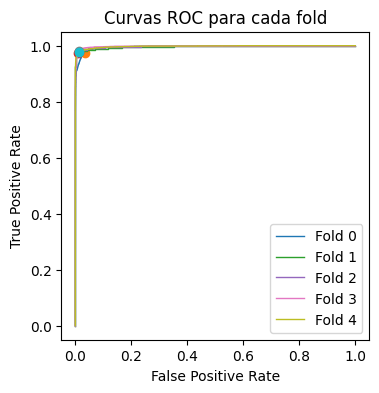

In [ ]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

thrs = []
tprs = []
fprs = []

fig, ax = plt.subplots(figsize=(4, 4))
for fold, (train, test) in enumerate(cv.split(X, y)):
    model.fit(X[train], y[train])
    y_pred = model.predict_proba(X[test])
    y_pred = y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)

    thrs.append(thresholdOpt)
    tprs.append(tprOpt)
    fprs.append(fprOpt)

    ax.step(
        fpr,
        tpr,
        label=f'Fold {fold}',
        lw=1,
        alpha=1,
    )

    ax.plot(
        fprOpt,
        tprOpt,
        marker = 'o'
    )

print(f'Umbrales óptimos:\n {thrs}')
print(f'Mejor umbral promedio: {np.mean(thrs)}')
print(f'Desvío umbral: {np.std(thrs)}')
print(f'FPR promedio: {np.mean(fprs)}, TPR promedio: {np.mean(tprOpt)}')

with open(experiment_name + 'Umbral.txt', 'w') as f:
    f.write('Mejor umbral promedio: ' + str(np.mean(thrs)))
    f.write('\n')
    f.write('FPR promedio: ' + str(np.mean(fprs)) + ' TPR promedio: ' + str(np.mean(tprOpt)))

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Curvas ROC para cada fold",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

## 2) Arbol de decisión

In [ ]:
from sklearn.model_selection import train_test_split

# X e y son las características e etiquetas, respectivamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.tree import DecisionTreeClassifier

# Inicializamos el clasificador de árbol de decisión
clfdt = DecisionTreeClassifier(random_state=42)

# Entrenamos el modelo
clfdt.fit(X_train, y_train)
dump(clfdt, 'decision_tree_model1.pkl')


['decision_tree_model1.pkl']

In [ ]:
# evaluamos el modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9795439786420377
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25080
         1.0       0.88      0.91      0.89      2638

    accuracy                           0.98     27718
   macro avg       0.94      0.95      0.94     27718
weighted avg       0.98      0.98      0.98     27718

[[24762   318]
 [  249  2389]]


In [ ]:
from sklearn.model_selection import cross_validate
import pandas as pd

# Diccionario de métricas para la validación cruzada
scoring = {
    'acc': 'accuracy',
    'prec': 'precision_macro',
    'rec': 'recall_macro',
    'f1': 'f1_macro',
    'b_acc': 'balanced_accuracy'
}

# Ejecutando la validación cruzada
scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=False)

# Convertir los resultados a DataFrame para un mejor manejo
df_scores = pd.DataFrame(scores)
print(df_scores)




    fit_time  score_time  test_acc  test_prec  test_rec   test_f1  test_b_acc
0  18.174700    0.107847  0.966917   0.886013  0.939643  0.910523    0.939643
1  17.758052    0.107059  0.977812   0.932532  0.940260  0.936352    0.940260
2  17.764459    0.119687  0.975792   0.920807  0.943536  0.931784    0.943536
3  19.464827    0.112184  0.975828   0.922108  0.941679  0.931607    0.941679
4  19.915043    0.069388  0.976260   0.926651  0.937861  0.932162    0.937861


In [ ]:
# Calculando los promedios de las métricas de validación cruzada
results = pd.DataFrame({
    'TIME': scores['fit_time'],
    'ACCURACY': scores['test_acc'],
    'PRECISION': scores['test_prec'],
    'RECALL': scores['test_rec'],
    'F1': scores['test_f1'],
    'B_ACCURACY': scores['test_b_acc']
}).mean()

# Imprimiendo los resultados
print(results)


TIME          20.845238
ACCURACY       0.974522
PRECISION      0.917622
RECALL         0.940596
F1             0.928486
B_ACCURACY     0.940596
dtype: float64


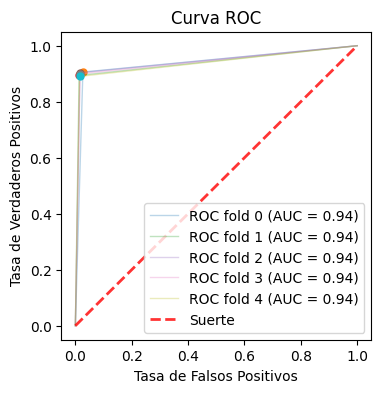

Umbrales óptimos:
 [1.0, 1.0, 1.0, 1.0, 1.0]
Mejor umbral promedio: 1.0
Desviación estándar del umbral: 0.0
FPR promedio: 0.01746, TPR promedio: 0.8986599999999999
AUC promedio: 0.94059580805045


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que 'clf' es tu modelo de árbol de decisión ya entrenado
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

thrs = []
tprs = []
fprs = []
aucs = []  # Para almacenar las puntuaciones AUC de cada fold

fig, ax = plt.subplots(figsize=(4, 4))
for fold, (train, test) in enumerate(cv.split(X, y)):
    # Entrenamos el modelo con los datos de entrenamiento de la partición actual
    clf.fit(X[train], y[train])
    # Predecimos las probabilidades en el conjunto de prueba de la partición actual
    y_pred = clf.predict_proba(X[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    roc_auc = auc(fpr, tpr)  # Calculamos el AUC
    aucs.append(roc_auc)  # Almacenamos el AUC

    # Encontramos el umbral óptimo
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits=4)
    fprOpt = round(fpr[index], ndigits=4)
    tprOpt = round(tpr[index], ndigits=4)

    # Almacenamos los valores óptimos
    thrs.append(thresholdOpt)
    tprs.append(tprOpt)
    fprs.append(fprOpt)

    # Graficamos la curva ROC para este fold
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {fold} (AUC = {roc_auc:.2f})')
    ax.plot(fprOpt, tprOpt, 'o', markersize=5)

# Configuramos el gráfico
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Suerte', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC")
ax.legend(loc="lower right")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.show()

# Imprimimos los resultados
print(f'Umbrales óptimos:\n {thrs}')
print(f'Mejor umbral promedio: {np.mean(thrs)}')
print(f'Desviación estándar del umbral: {np.std(thrs)}')
print(f'FPR promedio: {np.mean(fprs)}, TPR promedio: {np.mean(tprs)}')
print(f'AUC promedio: {np.mean(aucs)}')  # Imprimimos también el AUC promedio




In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape


(345, 512)

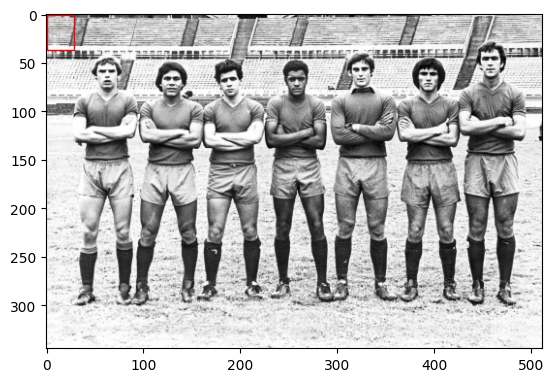

In [ ]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 0.6
Ni, Nj = (int(scale * s) for s in size)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [ ]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*sliding_window(test_image, scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch,
                                    orientations=orientations,
                                    pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(36652, 81)

In [ ]:
# Predicción
clf_dt = load('decision_tree_model1.pkl')
labels = clf_dt.predict(patches_hog).astype(int)
labels.sum()

929

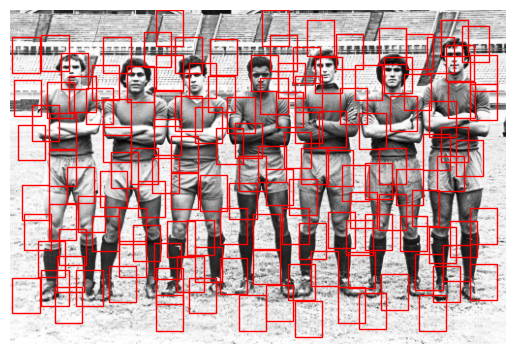

In [ ]:

Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralDecisionTree.png')

## 3) Gradient boosting


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

# Asumiendo que X e y son tus características y etiquetas, respectivamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializamos el clasificador de Gradient Boosting con árboles de profundidad 1
clf_gb = GradientBoostingClassifier(max_depth=1, random_state=42)

# Entrenamos el modelo
clf_gb.fit(X_train, y_train)
dump(clf_gb, 'gradient_boosting_model.pkl')

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = clf_gb.predict(X_test)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Diccionario de métricas para la validación cruzada
scoring = {
    'acc': 'accuracy',
    'prec': 'precision_macro',
    'rec': 'recall_macro',
    'f1': 'f1_macro',
    'b_acc': 'balanced_accuracy'
}

# Ejecutando la validación cruzada
scores = cross_validate(clf_gb, X, y, scoring=scoring, cv=5, return_train_score=False)
df_scores = pd.DataFrame(scores)
print(df_scores)
# Calculando los promedios de las métricas de validación cruzada
results = df_scores.mean()
print(results)

In [ ]:
# Configuración para la curva ROC
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

thrs = []
tprs = []
fprs = []
aucs = []  # Para almacenar las puntuaciones AUC de cada fold

fig, ax = plt.subplots(figsize=(4, 4))
for fold, (train, test) in enumerate(cv.split(X, y)):
    # Entrenamos el modelo con los datos de entrenamiento de la partición actual
    clf_gb.fit(X[train], y[train])
    # Predecimos las probabilidades en el conjunto de prueba de la partición actual
    y_pred = clf_gb.predict_proba(X[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    roc_auc = auc(fpr, tpr)  # Calculamos el AUC
    aucs.append(roc_auc)  # Almacenamos el AUC

    # Encontramos el umbral óptimo
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits=4)
    fprOpt = round(fpr[index], ndigits=4)
    tprOpt = round(tpr[index], ndigits=4)

    # Almacenamos los valores óptimos
    thrs.append(thresholdOpt)
    tprs.append(tprOpt)
    fprs.append(fprOpt)

    # Graficamos la curva ROC para este fold
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {fold} (AUC = {roc_auc:.2f})')
    ax.plot(fprOpt, tprOpt, 'o', markersize=5)

# Configuramos el gráfico
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Suerte', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC de Gradient Boosting")
ax.legend(loc="lower right")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.show()

# Imprimimos los resultados
print(f'Umbrales óptimos:\n {thrs}')
print(f'Mejor umbral promedio: {np.mean(thrs)}')
print(f'Desviación estándar del umbral: {np.std(thrs)}')
print(f'FPR promedio: {np.mean(fprs)}, TPR promedio: {np.mean(tprs)}')
print(f'AUC promedio: {np.mean(aucs)}')  # Imprimimos también el AUC promedio






In [ ]:
# Predicción
clf_dt = load('gradient_boosting_model.pkl')
labels = clf_dt.predict(patches_hog).astype(int)
labels.sum()

In [ ]:
Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralGradientBoosting.png')

## 4) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo Random Forest
clf_rf1 = RandomForestClassifier(n_estimators=10, random_state=42)
# Entrenar el modelo
clf_rf1.fit(X_train, y_train)
dump(clf_rf1, 'random_forest_model1.pkl')

['random_forest_model1.pkl']

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred = clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9898982610577963
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     25080
         1.0       1.00      0.90      0.94      2638

    accuracy                           0.99     27718
   macro avg       0.99      0.95      0.97     27718
weighted avg       0.99      0.99      0.99     27718

[[25073     7]
 [  273  2365]]


In [ ]:
# Diccionario de métricas para la validación cruzada
scoring = {
    'acc': 'accuracy',
    'prec': 'precision_macro',
    'rec': 'recall_macro',
    'f1': 'f1_macro',
    'b_acc': 'balanced_accuracy'
}

# Realizar la validación cruzada
scores = cross_validate(clf_rf, X, y, scoring=scoring, cv=5, return_train_score=False)
df_scores = pd.DataFrame(scores)
# Calcular los promedios de las métricas de validación cruzada
results = df_scores.mean()
print(results)

Calculando curva ROC: 100%|██████████| 5/5 [01:03<00:00, 12.70s/it]


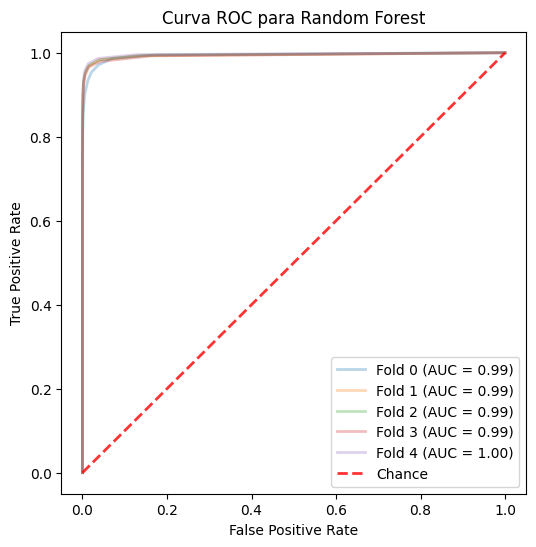

AUC promedio: 0.9944
Umbrales óptimos para cada fold: [0.3, 0.3, 0.3, 0.3, 0.3]
TPR promedio: 0.9698
FPR promedio: 0.0194


In [ ]:
# Configurar la validación cruzada estratificada para la curva ROC
cv = StratifiedKFold(n_splits=5)

# Listas para almacenar métricas de cada pliegue
thrs = []
tprs = []
fprs = []
aucs = []

# Calcular la curva ROC para cada pliegue
fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train, test) in tqdm(enumerate(cv.split(X, y)), total=cv.get_n_splits(), desc='Calculando curva ROC'):
    clf_rf.fit(X[train], y[train])
    # Verificar si el clasificador tiene el atributo `predict_proba`
    if hasattr(clf_rf, "predict_proba"):
        y_pred_prob = clf_rf.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Encuentra el umbral óptimo y almacena los valores correspondientes
        gmean = np.sqrt(tpr * (1 - fpr))
        index = np.argmax(gmean)
        thrs.append(thresholds[index])
        tprs.append(tpr[index])
        fprs.append(fpr[index])

        # Graficar la curva ROC para este pliegue
        ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Graficar la línea de suerte
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Configuración del gráfico
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC para Random Forest")
ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Imprimir los AUC promedios
print(f'AUC promedio: {np.mean(aucs):.4f}')
# Imprimir los umbrales óptimos, TPR y FPR promedio
print(f'Umbrales óptimos para cada fold: {thrs}')
print(f'TPR promedio: {np.mean(tprs):.4f}')
print(f'FPR promedio: {np.mean(fprs):.4f}')

In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape

(345, 512)

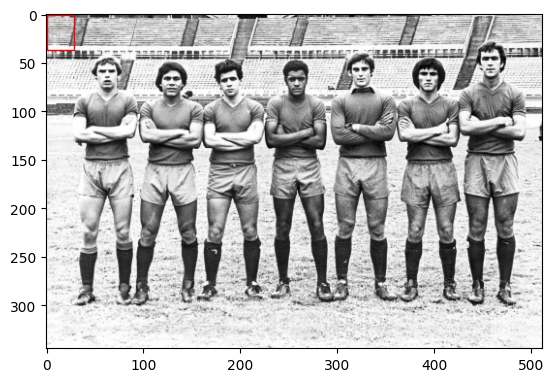

In [ ]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 0.6
Ni, Nj = (int(scale * s) for s in size)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [ ]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*sliding_window(test_image, scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch,
                                    orientations=orientations,
                                    pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(36652, 81)

In [ ]:
# Predicción
clf_rf1 = load('random_forest_model1.pkl')
labels = clf_rf1.predict(patches_hog).astype(int)
labels.sum()

136

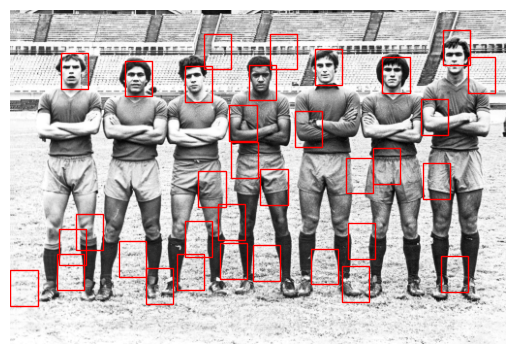

In [ ]:
Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralRandom1.png')

## 5) Random Forest II


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo Random Forest
clf_rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
# Entrenar el modelo
clf_rf2.fit(X_train, y_train)
dump(clf_rf2, 'random_forest_model2.pkl')

['random_forest_model2.pkl']

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred = clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9924597734324265
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     25080
         1.0       1.00      0.92      0.96      2638

    accuracy                           0.99     27718
   macro avg       0.99      0.96      0.98     27718
weighted avg       0.99      0.99      0.99     27718

[[25074     6]
 [  203  2435]]


In [ ]:
# Diccionario de métricas para la validación cruzada
scoring = {
    'acc': 'accuracy',
    'prec': 'precision_macro',
    'rec': 'recall_macro',
    'f1': 'f1_macro',
    'b_acc': 'balanced_accuracy'
}

# Realizar la validación cruzada
scores = cross_validate(clf_rf, X, y, scoring=scoring, cv=5, return_train_score=False)
df_scores = pd.DataFrame(scores)
# Calcular los promedios de las métricas de validación cruzada
results = df_scores.mean()
print(results)

fit_time      130.824295
score_time      0.495673
test_acc        0.991060
test_prec       0.987573
test_rec        0.960417
test_f1         0.973440
test_b_acc      0.960417
dtype: float64


In [ ]:
# Configurar la validación cruzada estratificada para la curva ROC
cv = StratifiedKFold(n_splits=5)

# Listas para almacenar métricas de cada pliegue
thrs = []
tprs = []
fprs = []
aucs = []

# Calcular la curva ROC para cada pliegue
fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train, test) in tqdm(enumerate(cv.split(X, y)), total=cv.get_n_splits(), desc='Calculando curva ROC'):
    clf_rf.fit(X[train], y[train])
    # Verificar si el clasificador tiene el atributo `predict_proba`
    if hasattr(clf_rf, "predict_proba"):
        y_pred_prob = clf_rf.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Encuentra el umbral óptimo y almacena los valores correspondientes
        gmean = np.sqrt(tpr * (1 - fpr))
        index = np.argmax(gmean)
        thrs.append(thresholds[index])
        tprs.append(tpr[index])
        fprs.append(fpr[index])

        # Graficar la curva ROC para este pliegue
        ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Graficar la línea de suerte
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Configuración del gráfico
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC para Random Forest")
ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Imprimir los AUC promedios
print(f'AUC promedio: {np.mean(aucs):.4f}')
# Imprimir los umbrales óptimos, TPR y FPR promedio
print(f'Umbrales óptimos para cada fold: {thrs}')
print(f'TPR promedio: {np.mean(tprs):.4f}')
print(f'FPR promedio: {np.mean(fprs):.4f}')

In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape

(345, 512)

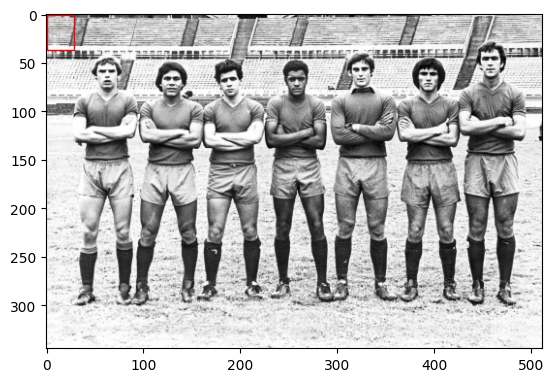

In [ ]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 0.6
Ni, Nj = (int(scale * s) for s in size)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [ ]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*sliding_window(test_image, scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch,
                                    orientations=orientations,
                                    pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(36652, 81)

In [ ]:
# Predicción
clf_rf2 = load('random_forest_model2.pkl')
labels = clf_rf2.predict(patches_hog).astype(int)
labels.sum()

107

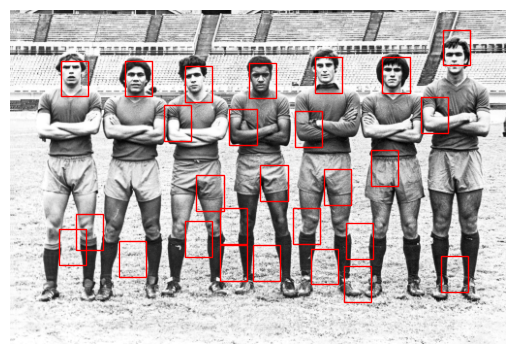

In [ ]:
Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralRandom2.png')

## 6) ADA Boosting


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo AdaBoost con DecisionTreeClassifier como base y 200 estimadores
base_estimator = DecisionTreeClassifier(max_depth=1)  # Base estimator
clf_ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=200,
    learning_rate=1.5,
    random_state=42
)


# Entrenar el modelo AdaBoost
clf_ada.fit(X_train, y_train)
dump(clf_ada, 'ada_model.pkl')

['ada_model.pkl']

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred = clf_ada.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9924236957933473
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     25080
         1.0       0.96      0.96      0.96      2638

    accuracy                           0.99     27718
   macro avg       0.98      0.98      0.98     27718
weighted avg       0.99      0.99      0.99     27718

[[24974   106]
 [  104  2534]]


In [ ]:
# Realizar la validación cruzada
scores = cross_validate(clf_ada, X, y, scoring=scoring, cv=5, return_train_score=False)
df_scores = pd.DataFrame(scores)

# Calcular los promedios de las métricas de validación cruzada
results = df_scores.mean()
print(results)

fit_time      435.570201
score_time      1.516347
test_acc        0.990533
test_prec       0.969366
test_rec        0.976855
test_f1         0.972940
test_b_acc      0.976855
dtype: float64


Calculando curva ROC: 100%|██████████| 5/5 [35:48<00:00, 429.74s/it]


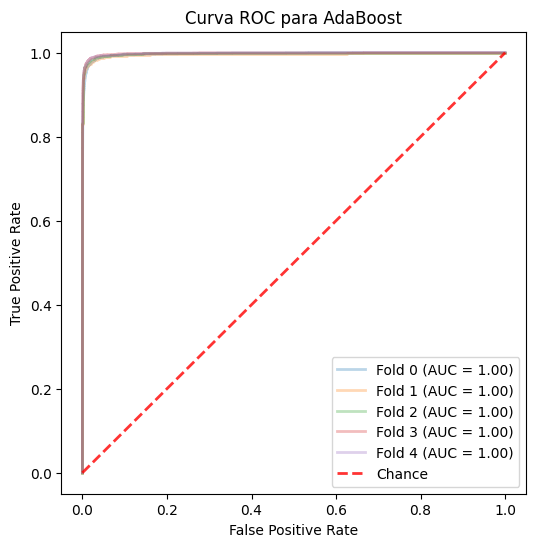

AUC promedio: 0.9977
Umbrales óptimos para cada fold: [0.49875998751964445, 0.4985539817674236, 0.49744734867747975, 0.497034181586437, 0.4973462104938855]
TPR promedio: 0.9787
FPR promedio: 0.0158


In [ ]:
# Configurar la validación cruzada estratificada para la curva ROC
cv = StratifiedKFold(n_splits=5)

# Listas para almacenar métricas de cada pliegue
thrs = []
tprs = []
fprs = []
aucs = []

# Calcular la curva ROC para cada pliegue
fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train, test) in tqdm(enumerate(cv.split(X, y)), total=cv.get_n_splits(), desc='Calculando curva ROC'):
    clf_ada.fit(X[train], y[train])
    y_pred_prob = clf_ada.predict_proba(X[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Encuentra el umbral óptimo y almacena los valores correspondientes
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thrs.append(thresholds[index])
    tprs.append(tpr[index])
    fprs.append(fpr[index])

    # Graficar la curva ROC para este pliegue
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Graficar la línea de suerte
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Configuración del gráfico
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC para AdaBoost")
ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Imprimir los AUC promedios y demás métricas
print(f'AUC promedio: {np.mean(aucs):.4f}')
print(f'Umbrales óptimos para cada fold: {thrs}')
print(f'TPR promedio: {np.mean(tprs):.4f}')
print(f'FPR promedio: {np.mean(fprs):.4f}')

In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape

(345, 512)

In [ ]:
# Predicción
clf_ada = load('ada_model.pkl')
labels = clf_ada.predict(patches_hog).astype(int)
labels.sum()

524

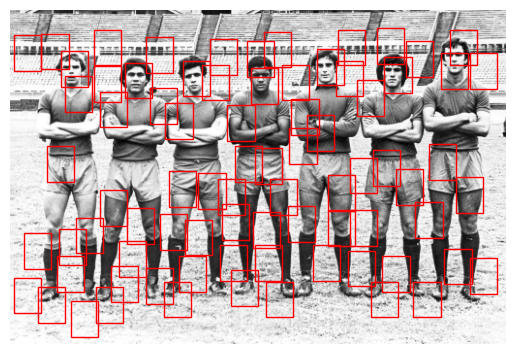

In [ ]:
Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralAda.png')

## 9) ADA BOOST 2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo AdaBoost con DecisionTreeClassifier como base y 200 estimadores
base_estimator = DecisionTreeClassifier(max_depth=6)  # Base estimator
clf_ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=200,
    learning_rate=1.5,
    random_state=42
)


# Entrenar el modelo AdaBoost
clf_ada.fit(X_train, y_train)
dump(clf_ada, 'ada2_model.pkl')

['ada2_model.pkl']

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred = clf_ada.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9960675373403565
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     25080
         1.0       1.00      0.96      0.98      2638

    accuracy                           1.00     27718
   macro avg       1.00      0.98      0.99     27718
weighted avg       1.00      1.00      1.00     27718

[[25075     5]
 [  104  2534]]


In [ ]:
# Realizar la validación cruzada
scores = cross_validate(clf_ada, X, y, scoring=scoring, cv=5, return_train_score=False)
df_scores = pd.DataFrame(scores)

# Calcular los promedios de las métricas de validación cruzada
results = df_scores.mean()
print(results)

fit_time      2379.136431
score_time       1.855655
test_acc         0.995014
test_prec        0.992038
test_rec         0.979028
test_f1          0.985394
test_b_acc       0.979028
dtype: float64


Calculando curva ROC: 100%|██████████| 5/5 [3:36:06<00:00, 2593.25s/it]


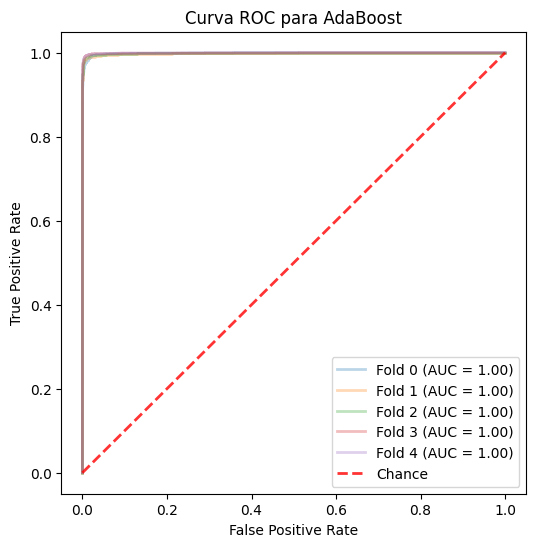

AUC promedio: 0.9990
Umbrales óptimos para cada fold: [0.3666550583323742, 0.3279108787763111, 0.35732013801094487, 0.2998470271551304, 0.3384756338539732]
TPR promedio: 0.9891
FPR promedio: 0.0094


In [ ]:
# Configurar la validación cruzada estratificada para la curva ROC
cv = StratifiedKFold(n_splits=5)

# Listas para almacenar métricas de cada pliegue
thrs = []
tprs = []
fprs = []
aucs = []

# Calcular la curva ROC para cada pliegue
fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train, test) in tqdm(enumerate(cv.split(X, y)), total=cv.get_n_splits(), desc='Calculando curva ROC'):
    clf_ada.fit(X[train], y[train])
    y_pred_prob = clf_ada.predict_proba(X[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Encuentra el umbral óptimo y almacena los valores correspondientes
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thrs.append(thresholds[index])
    tprs.append(tpr[index])
    fprs.append(fpr[index])

    # Graficar la curva ROC para este pliegue
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Graficar la línea de suerte
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Configuración del gráfico
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC para AdaBoost")
ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Imprimir los AUC promedios y demás métricas
print(f'AUC promedio: {np.mean(aucs):.4f}')
print(f'Umbrales óptimos para cada fold: {thrs}')
print(f'TPR promedio: {np.mean(tprs):.4f}')
print(f'FPR promedio: {np.mean(fprs):.4f}')

In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape

(345, 512)

In [ ]:
# Predicción
clf_ada = load('ada2_model.pkl')
labels = clf_ada.predict(patches_hog).astype(int)
labels.sum()

159

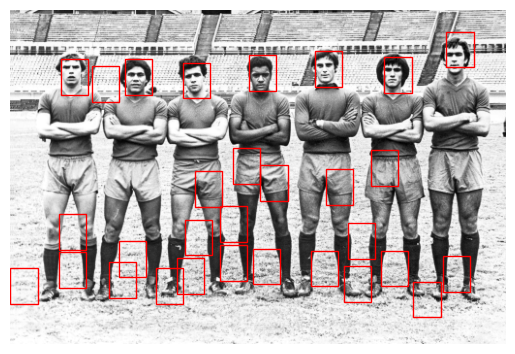

In [ ]:
Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralAda.png')

## 7) RED NEURONAL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # Capa de entrada y primera capa oculta
model.add(Dense(32, activation='relu'))  # Segunda capa oculta
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
model.save('redesNeuronales1.h5')

Epoch 1/10
2772/2772 [==============================] - 11s 4ms/step - loss: 0.0481 - accuracy: 0.9839 - val_loss: 0.0233 - val_accuracy: 0.9920
Epoch 2/10
2772/2772 [==============================] - 7s 3ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0210 - val_accuracy: 0.9932
Epoch 3/10
2772/2772 [==============================] - 10s 3ms/step - loss: 0.0186 - accuracy: 0.9945 - val_loss: 0.0166 - val_accuracy: 0.9948
Epoch 4/10
2772/2772 [==============================] - 7s 3ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 5/10
2772/2772 [==============================] - 10s 4ms/step - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0168 - val_accuracy: 0.9949
Epoch 6/10
2772/2772 [==============================] - 7s 3ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.0194 - val_accuracy: 0.9940
Epoch 7/10
2772/2772 [==============================] - 10s 4ms/step - loss: 0.0143 - accuracy: 0.9959 - val_loss: 0.0143 - val_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

print("Evaluación en el conjunto de prueba:")
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

867/867 [==============================] - 2s 2ms/step
Evaluación en el conjunto de prueba:
[[24959   121]
 [   46  2592]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     25080
         1.0       0.96      0.98      0.97      2638

    accuracy                           0.99     27718
   macro avg       0.98      0.99      0.98     27718
weighted avg       0.99      0.99      0.99     27718



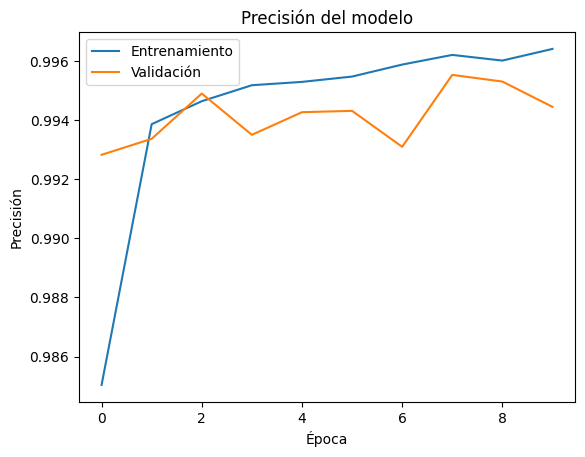

In [ ]:
# Opcional: Visualizar el proceso de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

867/867 [==============================] - 2s 3ms/step


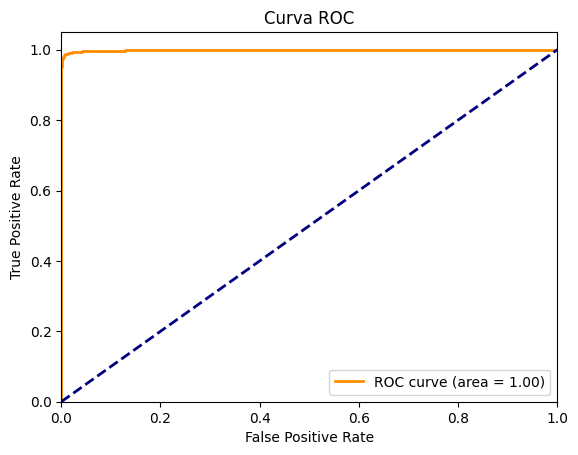

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# Obtener las probabilidades predichas para la clase positiva
y_pred_probs = model.predict(X_test)

# Calcular FPR, TPR y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape


In [ ]:
# Predicción
from tensorflow.keras.models import load_model


modelo_cargado = load_model('redesNeuronales1.h5')
# Asumiendo que 'patches_hog' contiene tus datos preprocesados
y_pred = modelo_cargado.predict(patches_hog)
labels = (y_pred > 0.5).astype(int)  # Para clasificación binaria
total_labels = labels.sum()
print(total_labels)


1146/1146 [==============================] - 3s 2ms/step
125


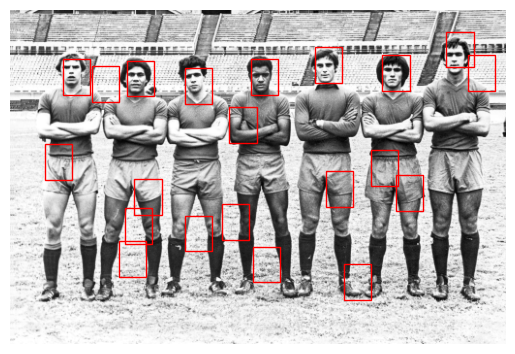

In [ ]:
# Asumiendo que tienes las variables test_image, scale, y size definidas correctamente
Ni, Nj = (int(scale * s) for s in size)

# Asumiendo que 'labels' contiene las predicciones de tu modelo de red neuronal
indices = np.array(indices)
detecciones = indices[labels.flatten() == 1]  # Aplanar labels si es necesario
detecciones = non_max_suppression(detecciones, Ni, Nj, 0.3)

# Visualizar las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralRedesNeuronales1.png')


## 8) Red Neuronal 2
 Neuronales 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el segundo modelo de red neuronal
model_2 = Sequential()

# Capa de entrada y primera capa oculta con más neuronas
model_2.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))

# Añadir Dropout para reducir el sobreajuste
model_2.add(Dropout(0.5))

# Segunda capa oculta
model_2.add(Dense(64, activation='relu'))

# Tercera capa oculta
model_2.add(Dense(32, activation='relu'))

# Capa de salida para clasificación binaria
model_2.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con un optimizador diferente
model_2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)
model.save('redesNeuronales2.h5')

Epoch 1/15
693/693 [==============================] - 4s 4ms/step - loss: 0.3500 - accuracy: 0.8955 - val_loss: 0.3082 - val_accuracy: 0.9014
Epoch 2/15
693/693 [==============================] - 2s 3ms/step - loss: 0.2855 - accuracy: 0.9052 - val_loss: 0.2591 - val_accuracy: 0.9014
Epoch 3/15
693/693 [==============================] - 2s 3ms/step - loss: 0.2205 - accuracy: 0.9063 - val_loss: 0.1565 - val_accuracy: 0.9144
Epoch 4/15
693/693 [==============================] - 3s 4ms/step - loss: 0.1353 - accuracy: 0.9443 - val_loss: 0.0860 - val_accuracy: 0.9743
Epoch 5/15
693/693 [==============================] - 4s 6ms/step - loss: 0.0881 - accuracy: 0.9725 - val_loss: 0.0610 - val_accuracy: 0.9821
Epoch 6/15
693/693 [==============================] - 4s 6ms/step - loss: 0.0699 - accuracy: 0.9784 - val_loss: 0.0514 - val_accuracy: 0.9840
Epoch 7/15
693/693 [==============================] - 3s 4ms/step - loss: 0.0601 - accuracy: 0.9819 - val_loss: 0.0454 - val_accuracy: 0.9859
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred_2 = model_2.predict(X_test)
y_pred_classes_2 = (y_pred_2 > 0.5).astype("int32")

print("Evaluación en el conjunto de prueba para el segundo modelo:")
print(confusion_matrix(y_test, y_pred_classes_2))
print(classification_report(y_test, y_pred_classes_2))

867/867 [==============================] - 2s 2ms/step
Evaluación en el conjunto de prueba para el segundo modelo:
[[25001    79]
 [  158  2480]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     25080
         1.0       0.97      0.94      0.95      2638

    accuracy                           0.99     27718
   macro avg       0.98      0.97      0.97     27718
weighted avg       0.99      0.99      0.99     27718



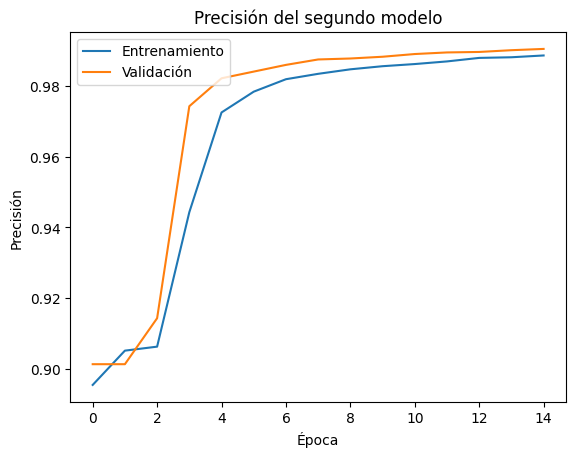

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Precisión del segundo modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

867/867 [==============================] - 2s 2ms/step


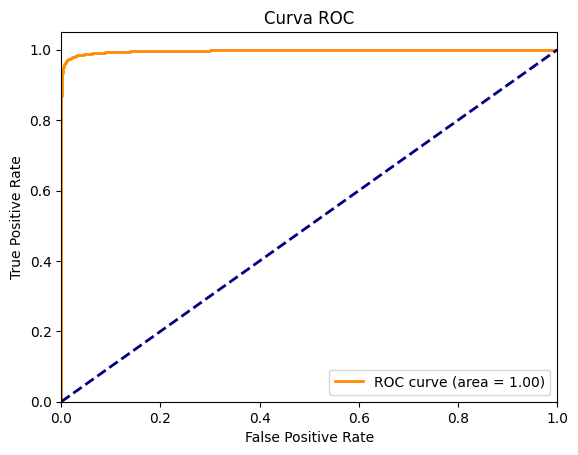

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# Obtener las probabilidades predichas para la clase positiva
y_pred_probs = model_2.predict(X_test)

# Calcular FPR, TPR y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
test_image = plt.imread('/content/drive/MyDrive/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape


(345, 512)

In [ ]:
# Predicción
from tensorflow.keras.models import load_model


modelo_cargado2 = load_model('redesNeuronales2.h5')
# Asumiendo que 'patches_hog' contiene tus datos preprocesados
y_pred = modelo_cargado2.predict(patches_hog)
labels2 = (y_pred > 0.5).astype(int)  # Para clasificación binaria
total_labels2 = labels2.sum()
print(total_labels2)


1146/1146 [==============================] - 3s 2ms/step
125


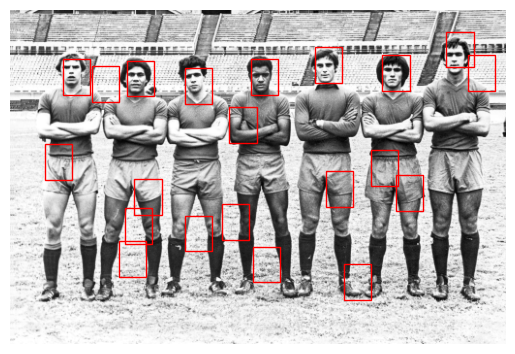

In [ ]:
# Asumiendo que tienes las variables test_image, scale, y size definidas correctamente
Ni, Nj = (int(scale * s) for s in size)

# Asumiendo que 'labels' contiene las predicciones de tu modelo de red neuronal
indices = np.array(indices)
detecciones2 = indices[labels2.flatten() == 1]  # Aplanar labels si es necesario
detecciones2 = non_max_suppression(detecciones2, Ni, Nj, 0.3)

# Visualizar las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones2:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralRedesNeuronales2.png')


## 10) ADA BOOST con Regresión Logistica

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Asumiendo que X e y ya están definidos y son tus datos y etiquetas

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo AdaBoost con LogisticRegression como base y 100 estimadores
base_estimator = LogisticRegression()  # Base estimator
clf_ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1,
    random_state=42
)

# Entrenar el modelo AdaBoost
clf_ada.fit(X_train, y_train)
dump(clf_ada, 'ada_logistic_model.pkl')

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_pred = clf_ada.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Realizar la validación cruzada
scoring = ['accuracy', 'precision', 'recall', 'f1']  # Asegúrate de definir las métricas que deseas usar
scores = cross_validate(clf_ada, X, y, scoring=scoring, cv=5, return_train_score=False)
df_scores = pd.DataFrame(scores)
# Calcular los promedios de las métricas de validación cruzada
results = df_scores.mean()
print(results)

In [ ]:
# Configurar la validación cruzada estratificada para la curva ROC
cv = StratifiedKFold(n_splits=5)

# Listas para almacenar métricas de cada pliegue
thrs = []
tprs = []
fprs = []
aucs = []

# Calcular la curva ROC para cada pliegue
fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train, test) in tqdm(enumerate(cv.split(X, y)), total=cv.get_n_splits(), desc='Calculando curva ROC'):
    clf_ada.fit(X[train], y[train])
    y_pred_prob = clf_ada.predict_proba(X[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Encuentra el umbral óptimo y almacena los valores correspondientes
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thrs.append(thresholds[index])
    tprs.append(tpr[index])
    fprs.append(fpr[index])

    # Graficar la curva ROC para este pliegue
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Graficar la línea de suerte
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Configuración del gráfico
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Curva ROC para AdaBoost con Logistic Regression")
ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Imprimir los AUC promedios y demás métricas
print(f'AUC promedio: {np.mean(aucs):.4f}')
print(f'Umbrales óptimos para cada fold: {thrs}')
print(f'TPR promedio: {np.mean(tprs):.4f}')
print(f'FPR promedio: {np.mean(fprs):.4f}')


In [ ]:
# Predicción
clf_rf = load('ada_logistic_model.pkl')
labels = clf_rf.predict(patches_hog).astype(int)
labels.sum()

In [ ]:
Ni, Nj = (int(scale*s) for s in size)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=1, lw=1, facecolor='none'))

plt.savefig('test_centralAdaBoostConLogisticReg.png')